In [ ]:
!nvidia-smi
#Check allocated GPU

# Introduction to Spam Email Classification

Have you ever wondered how your email client identifies and filters spam emails? Why do some emails end up in the 'junk' folder?

In this assignment, we will explore spam email classification using Convolutional Neural Networks (CNNs).

These algorithms are needed because the internet is flooded with spam emails that can be annoying, deceptive, or even harmful. Effective spam classification is important for improving user experience and protecting against threats. Traditional methods, like rule-based filters and Bayesian classifiers, often fail due to the changing tactics of spam. This is where machine learning, especially CNNs, becomes important. By learning patterns from a large dataset of labeled emails, CNNs can classify emails accurately.


# **Part 1** Preprocessing the emails for training

## Data loading

First, we load the email dataset into the Colab runtime.

In [11]:
import zipfile
from google.colab import files

# Upload file
uploaded = files.upload()

# Extract the zip file
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall()
        print(f"Extracted {filename}")

Saving spam_email.zip to spam_email (1).zip
Extracted spam_email (1).zip


In [3]:
DATA_PATH = '/content/emails.csv'

In [12]:
import pandas as pd

df = pd.read_csv('emails.csv')
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


## Step 0: Clean the emails

The first step is to clean the email text by removing punctuation and converting all characters to lowercase.

In [13]:
# Clean email.  Remove punctuations, caps, HTML entities

import sys
import subprocess
import warnings
import os
from collections import Counter
from html import unescape
import re
import numpy as np

def clean_email(text):
    text = text.lower()  # Convert to lowercase
    text = unescape(text)  # Decode HTML entities like &amp; or &lt;
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'\\[a-z]', ' ', text)  # Remove any escape sequences like \n, \t
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z ]', '', text)  # Remove special characters and numbers
    text = re.sub(' +', ' ', text)  # Replace multiple spaces with single space
    return text.strip()  # Strip leading/trailing spaces

if __name__ == '__main__':
    warnings.filterwarnings("ignore", category=UserWarning) # Mute HuggingFace warnings temporarily
    original_stderr = sys.stderr
    sys.stderr = open('/dev/null', 'w') # Mute Linux dependency stderr temporarily
    try:
        subprocess.run(['pip', 'install', 'datasets'], check=True)
    finally: # Restore stderr and warnings
        sys.stderr.close()
        sys.stderr = original_stderr
        warnings.filterwarnings("default", category=UserWarning)

    from datasets import load_dataset
    print("Loading dataset...")
    ds = load_dataset('csv', data_files=DATA_PATH)

    SUBSET_SIZE = 1000  # Define the size of loaded subset
    if 'train' in ds:
        ds = ds['train'].shuffle(seed=42).select(range(SUBSET_SIZE))

        print("Cleaning emails...")
        labels_of_emails = []
        cleaned_emails = []
        for email in ds:
          cleaned_emails.append(clean_email(email['text']))
          labels_of_emails.append(email['spam'])

        print("Sample cleaned email:", cleaned_emails[:30])
        print("Sample label:", labels_of_emails[:30])  # 0 means ham (not spam) and 1 means spam
        print("Labels_of_emails length:", len(labels_of_emails))
    else:
        print("Failed to load the dataset.")

    os.makedirs("models", exist_ok=True) # create a new folder "models" to save your model


Loading dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Cleaning emails...
Sample cleaned email: ['subject re urgent deadline rsvp by jan nd invitation to energy finance conference feb the university of texas at austin karen i shall attend the conference both days vince kaminski from karen marshall pm to david haug enron development enron development gary hickerson hou ect ect craig childers hou ees ees thomas suffield na enron enron ben f glisan hou ect ect ermes melinchon enron development enron development hal elrod corp enron enron clay spears hou ect ect kelly mahmoud hou ect ect ellen fowler enron communications enron communications kevin kuykendall hou ect ect fred mitro hou ect ect kyle kettler hou ect ect jeff bartlett hou ect ect paul j broderick hou ect ect john house hou ect ect george mccormick hou ect ect guido caranti enron development enron development ken sissingh corp enron enron gwynn gorsuch na enron enron mark gandy enron communications enron communications shawn cumberland enron development enron development jennifer m

## Step 1: Create the vocabulary and mapping

Next, use the cleaned text to create the following **four** variables. It's important to note that to manage the corpus size and filter out uncommon or infrequent words, our vocabulary (vocab) should include only words that appear **at least 5 times** in `cleaned_emails` (a list of strings where each entry is a cleaned email text).


These variables are used to create a vocabulary model that maps words to indices and allows us to index words back to their original form. This process filters the vocabulary to include only frequently used words, optimizing memory usage and computation efficiency in later steps.

In [14]:
# STEP 1:  Compile corpus, create vocab, vocab_size, word_to_index, index_to_word

def create_vocabulary(cleaned_emails):
    """
    Processes a list of cleaned email texts to generate a vocabulary and associated mappings.

    Args:
        cleaned_emails (list of str): A list where each entry is a cleaned email text.

    Returns:
        vocab (list of str): A **sorted** list of unique words appearing 5 or more times.
        vocab_size (int): The number of unique words in the vocabulary.
        word_to_index (dict of str: int): A dictionary mapping each word in `vocab` to a unique integer index.
        index_to_word (dict of int: str): A dictionary mapping each integer index back to the corresponding word in `vocab`.
    """

    word_to_index = {}
    index_to_word = {}

    cleaned_text = ' '.join(cleaned_emails)
    words = cleaned_text.split()
    word_counts = Counter(words)
    ordered_words = [word for word in words if word_counts[word] >= 5]
    vocab = list(set(ordered_words))
    vocab.sort()
    vocab_size = len(vocab)
    for index, word in enumerate(vocab):
        word_to_index[word] = index
        index_to_word[index] = word

    # do not modify this
    return vocab, vocab_size, word_to_index, index_to_word

# Create the vocabulary
if __name__ == '__main__':
    vocab, vocab_size, word_to_index, index_to_word = create_vocabulary(cleaned_emails)


    # Sample outputs:
    print(f"Number of Unique Words that appear >=5 times (size of the vocabulary): {vocab_size}\n")

    print(f"Case 1")
    print(f"vocab samples: {vocab[:20]}")
    print(f"word_to_index samples: {list(word_to_index.items())[:20]}")
    print(f"index_to_word samples: {list(index_to_word.items())[:20]}\n")

    print(f"Case 2")
    print(f"vocab samples: {vocab[1000:1020]}")
    print(f"word_to_index samples: {list(word_to_index.items())[1000:1020]}")
    print(f"index_to_word samples: {list(index_to_word.items())[1000:1020]}\n")

    print(f"Case 3")
    print(f"vocab samples: {vocab[4000:4020]}")
    print(f"word_to_index samples: {list(word_to_index.items())[4000:4020]}")
    print(f"index_to_word samples: {list(index_to_word.items())[4000:4020]}\n")


Number of Unique Words that appear >=5 times (size of the vocabulary): 4484

Case 1
vocab samples: ['a', 'aa', 'ab', 'abhay', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'abstract', 'abuse', 'ac', 'academic', 'academics', 'acadia', 'accept', 'acceptable', 'acceptance', 'accepted']
word_to_index samples: [('a', 0), ('aa', 1), ('ab', 2), ('abhay', 3), ('ability', 4), ('able', 5), ('about', 6), ('above', 7), ('absolute', 8), ('absolutely', 9), ('abstract', 10), ('abuse', 11), ('ac', 12), ('academic', 13), ('academics', 14), ('acadia', 15), ('accept', 16), ('acceptable', 17), ('acceptance', 18), ('accepted', 19)]
index_to_word samples: [(0, 'a'), (1, 'aa'), (2, 'ab'), (3, 'abhay'), (4, 'ability'), (5, 'able'), (6, 'about'), (7, 'above'), (8, 'absolute'), (9, 'absolutely'), (10, 'abstract'), (11, 'abuse'), (12, 'ac'), (13, 'academic'), (14, 'academics'), (15, 'acadia'), (16, 'accept'), (17, 'acceptable'), (18, 'acceptance'), (19, 'accepted')]

Case 2
vocab samples: ['dave

## Step 2: Encode the emails

After completing the preparation work in the previous step, you need to create `encode_emails` to encode a list of cleaned email texts into sequences of integers. Each word in an email will be represented by a unique integer index from the `word_to_index` dictionary.

The vocabulary includes words that appear at least 5 times in the corpus, ensuring that only frequent and meaningful words are included, while infrequent or possibly incorrect words are encoded as 0.

To efficiently check if a word is in the vocabulary, consider converting the `vocab` list into a **`set`**. A `set` provides faster lookup than a `list` because it uses a hash table for implementation.




In [15]:
# STEP 2: Encode the emails

def encode_emails(cleaned_emails, vocab, word_to_index):
    """
    Encodes a list of cleaned email texts into sequences of integers.

    Args:
        cleaned_emails (list of str): A list where each entry is a cleaned email text.
        vocab (list of str): List of words that appear at least 5 times in the corpus.
        word_to_index (dict of str: int): A dictionary mapping each word to a unique integer index.

    Returns:
        encoded_emails (list of [list of int]): A list of lists, where each inner list is a sequence of integers representing a cleaned email.
    """
    encoded_emails = []

    vocab = set(vocab)
    for email in cleaned_emails:
        encoded_email = []
        words = email.split()
        for word in words:
            if word in vocab:
                encoded_email.append(word_to_index[word])
            else:
                encoded_email.append(0) # words not in the vocab
        encoded_emails.append(encoded_email)

    return encoded_emails


if __name__ == '__main__': # Encode the emails
    encoded_emails = encode_emails(cleaned_emails, vocab, word_to_index)


    # Sample outputs:
    print(f"Case 1")
    print(f"Sample email content: \n{cleaned_emails[0]}")
    print(f"Encoded email: \n{encoded_emails[0]}\n")

    print(f"Case 2")
    print(f"Sample email content: \n{cleaned_emails[341]}")
    print(f"Encoded email: \n{encoded_emails[341]}\n")

    print(f"Case 3")
    print(f"Sample email content: \n{cleaned_emails[923]}")
    print(f"Encoded email: \n{encoded_emails[923]}\n")

Case 1
Sample email content: 
subject re urgent deadline rsvp by jan nd invitation to energy finance conference feb the university of texas at austin karen i shall attend the conference both days vince kaminski from karen marshall pm to david haug enron development enron development gary hickerson hou ect ect craig childers hou ees ees thomas suffield na enron enron ben f glisan hou ect ect ermes melinchon enron development enron development hal elrod corp enron enron clay spears hou ect ect kelly mahmoud hou ect ect ellen fowler enron communications enron communications kevin kuykendall hou ect ect fred mitro hou ect ect kyle kettler hou ect ect jeff bartlett hou ect ect paul j broderick hou ect ect john house hou ect ect george mccormick hou ect ect guido caranti enron development enron development ken sissingh corp enron enron gwynn gorsuch na enron enron mark gandy enron communications enron communications shawn cumberland enron development enron development jennifer martinez hou e

## Step 3: Create paddings

Since the CNN requires uniform input length, you will implement a function that pads or truncates sequences of integers representing encoded email texts to a maximum length of **`ENCODE_LENGTH` = 300**. You will create a function that takes a list of encoded email sequences (`encoded_emails`) and outputs a 2D numpy array, where each row is a padded or truncated sequence of integers.

Padding is needed for sequences of varying lengths, while truncation is used for sequences that exceed a certain length. Padding will be performed with zeros added to the right of the sequences, and truncation will remove extra integers from the end. This ensures all sequences have the same fixed length, which is essential for further processing in machine learning models.



In [16]:
# STEP 3: Create paddings (and truncations)

def pad_encoded_emails(encoded_emails, max_len = 300):
    """
    Pads or truncates encoded email sequences to a specified length using NumPy.

    Args:
        encoded_emails (list of list of int): A list of lists, where each inner list is a sequence of integers representing a cleaned email.
        max_len (int): The maximum length of the sequences after padding/truncation.

    Returns:
        padded_emails (numpy array of shape (num_emails, max_len)): A 2D numpy array containing the padded/truncated email sequences.
    """
    # Initialize an array of zeros with shape (number of emails, max_len)
    padded_emails = np.zeros((len(encoded_emails), max_len), dtype=int)

    for i, email in enumerate(encoded_emails):
        if len(email) > max_len:
            padded_emails[i, :max_len] = email[:max_len] # Truncate the sequence if it's longer than max_len
        else:
            padded_emails[i, :len(email)] = email # Otherwise, copy the entire sequence and the rest remains zero (padding)

    return padded_emails

if __name__ == '__main__': # Pad/Truncate the encoded emails
    ENCODE_LENGTH = 300
    padded_emails = pad_encoded_emails(encoded_emails, max_len=ENCODE_LENGTH)

    # Sample outputs:
    print(f"Shape of padded emails: {padded_emails.shape}\n")

    print(f"Case 1")
    print(f"Sample padded email: {padded_emails[0]}\n")

    print(f"Case 2")
    print(f"Sample padded email: {padded_emails[821]}\n")

    print(f"Case 3")
    print(f"Sample padded email: {padded_emails[345]}\n")





Shape of padded emails: (1000, 300)

Case 1
Sample padded email: [3887 3248 4217 1009 3488  527 2123 2638 2074 4076 1310 1549  808 1515
 4018 4195 2726 4009  300  328 2181 1912 3638  309 4018  808  467 1006
 4285 2179 1644 2181 2458 2978 4076 1001    0 1328 1096 1328 1096 1679
 1847 1887 1236 1236  940    0 1887 1250 1250 4040    0 2621 1328 1328
  413 1477    0 1887 1236 1236    0    0 1328 1096 1328 1096    0    0
  899 1328 1328    0    0 1887 1236 1236 2190    0 1887 1236 1236    0
    0 1328  764 1328  764 2194    0 1887 1236 1236    0    0 1887 1236
 1236    0    0 1887 1236 1236 2134    0 1887 1236 1236 2874 2115    0
 1887 1236 1236 2152 1891 1887 1236 1236 1700    0 1887 1236 1236    0
    0 1328 1096 1328 1096 2191    0  899 1328 1328    0    0 2621 1328
 1328 2448 1672 1328  764 1328  764    0    0 1328 1096 1328 1096 2136
    0 1887 1236 1236 3557    0 1887 1236 1236    0    0 1887 1236 1236
  490    0 1328  764 1328  764  437    0 1328  764 1328  764 2874    0
 1328  764 1

# **Part 2** Compiling and training spam email classification model

## Step 4: Build the CNN model

After preprocessing your data, you will build a Convolutional Neural Network (CNN) for text classification. The model will process input text sequences that have been converted into numerical representations through previous encoding and padding.

The model will have two inputs:
*  `vocab_size`: The size of the vocabulary in your dataset, which sets the input dimension for the embedding layer.
*  `input_length`: The length of the input sequences, which is equal to `ENCODE_LENGTH` from step 3.


## What is an Embedding?

In language processing, an **embedding** transforms words from discrete indices into dense vectors that capture semantic relationships. This is important because raw integer representations lack meaning—words like 'urgent' and 'important' may have different indices but should be treated similarly.

An **embedding** layer addresses this by learning a semantic representation of words during training, converting each word index into a dense, low-dimensional vector (embedding). These vectors encode semantic information, so words with similar meanings will have similar vector representations. This is especially important in text classification tasks, as understanding word relationships helps the model make better predictions.

The embedding layer in the your model will convert these integer sequences into meaningful dense vectors. This prepares the data for further processing by the convolutional layers, which will extract relevant features for classification and enable the model to learn patterns and relationships between words.

In [17]:
# STEP 4:  Build the model

SEED = 2211
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import set_random_seed
set_random_seed(SEED)


def build_model(vocab_size, input_length):
    """
    build the CNN model for binary classification of spam email.

    Args:
        vocab_size (int): The size of the vocabulary.
        input_length (int): The length of input sequences.

    Returns:
        Sequential: The compiled CNN model.
    """

    model = Sequential()

    model.add(Input((input_length,),batch_size=32))

    # Embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=input_length))

    # A Convolutional Block
    model.add(Conv1D(filters=32, kernel_size=16, activation='relu', kernel_initializer = 'he_normal'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=16, activation='relu', kernel_initializer = 'he_normal'))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten the output
    model.add(Flatten())

    # Fully connected
    model.add(Dense(units=64, activation='relu', kernel_initializer = 'he_normal'))
    model.add(Dropout(0.5))

    # Binary output
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer = 'he_normal'))

    return model

if __name__ == "__main__":

    X_train, X_test, y_train, y_test = train_test_split(padded_emails, labels_of_emails, test_size=0.3, random_state=SEED)
    X_train = np.array(X_train)
    print(np.sum(X_train[0]))
    print(np.sum(X_test[0]))
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Training labels shape: {len(y_train)}")
    print(f"Test labels shape: {len(y_test)}")

    # create the model
    model = build_model(vocab_size, X_train.shape[1] ) # (vocab_size, 300)
    print(model.summary())

371996
341653
Training data shape: (700, 300)
Test data shape: (300, 300)
Training labels shape: 700
Test labels shape: 300


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 300, 300)         │     1,345,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (32, 285, 32)          │       153,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (32, 142, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (32, 127, 64)          │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (32, 63, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 4032)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       258,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,789,841 (6.83 MB)

 Trainable params: 1,789,841 (6.83 MB)

 Non-trainable params: 0 (0.00 B)

None


## Step 5: Compile and Train the model

It's time to test the model!

** Overview of Steps: **

1. **Model Compilation**:
   - In this step, we will compile the CNN model using the [model.compile( )](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) method.
     - **Optimizer**: This controls the learning process. You will use the `Adam` optimizer.
     - **Loss Function**: This measures how well the model's predictions match the true labels. For binary classification, `binary_crossentropy` is appropriate. (Use `categorical_crossentropy` for multi-class classification.)
     - **Metrics**: These evaluate the model's performance during training. We will use the `accuracy` metric to track the proportion of correctly classified instances.

2. **Model Training**:
   - After compiling the model, we will train it using the [model.fit( )](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method.
      - This involves providing the model with training data and labels (`X_train` and `y_train`) for several epochs. An epoch represents one complete pass through the training dataset.
      - **Set `epochs` = 25** and  it is recommended to set `batch_size = 32`.
      - We will also use `validation_data` (`X_test` and `y_test`) to monitor the model's performance after each epoch, which helps prevent overfitting.

3. **Callbacks**:
   - Callbacks are tools provided by Keras to customize the training process.
     - **ModelCheckpoint**: This saves the best version of the model during training based on its performance on the validation set.


In [18]:
# STEP 5:  Compile and Train the model

import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


def compile_and_train_model(model, X_train, y_train, X_test, y_test,
                            weights_save_path='model_pa2_cnn.keras',
                            epochs=25, batch_size=32):
    """
    Compiles and trains the given model.

    Parameters:
    - model: The Keras model to compile and train.
    - X_train: Training data features.
    - y_train: Training data labels.
    - X_test: Validation data features.
    - y_test: Validation data labels.
    - weights_save_path: Path to save the best model weights (default is 'model_pa2_cnn.keras').
    - epochs: Number of training epochs (default is 25).
    - batch_size: Batch size for training (default is 32).

    Returns:
    - history: Training history object.
    - model: The trained Keras model.
    """

    # Set up ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(filepath=weights_save_path,
                                       save_best_only=True,
                                       monitor='val_loss',
                                       verbose=1)

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[model_checkpoint])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return history, model

if __name__ == '__main__':
    # Call the function to compile, train, evaluate, and save the model
    history, trained_model = compile_and_train_model(model, X_train, y_train, X_test, y_test)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7009 - loss: 0.5549
Epoch 1: val_loss improved from inf to 0.24995, saving model to model_pa2_cnn.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.7019 - loss: 0.5511 - val_accuracy: 0.7900 - val_loss: 0.2499
Epoch 2/25
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8065 - loss: 0.2593
Epoch 2: val_loss improved from 0.24995 to 0.20203, saving model to model_pa2_cnn.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8230 - loss: 0.2534 - val_accuracy: 0.9433 - val_loss: 0.2020
Epoch 3/25
16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9791 - loss: 0.2065
Epoch 3: val_loss did not improve from 0.20203
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9783 - loss: 0.2052 - val_accuracy: 0.9367 - val_loss: 0.2163
Epoch 4/25
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9804 - loss: 0.1866
Epoch 4: val_loss improved from 0.20203 to 0.17256, saving model to model_pa2_cnn.keras
22/22 

# **Part 3** Visualising the outcome

Now that the model is trained, use the following code to evaluate and visualize your results!

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9767 - loss: 0.0719
Validation accuracy: 0.9666666388511658


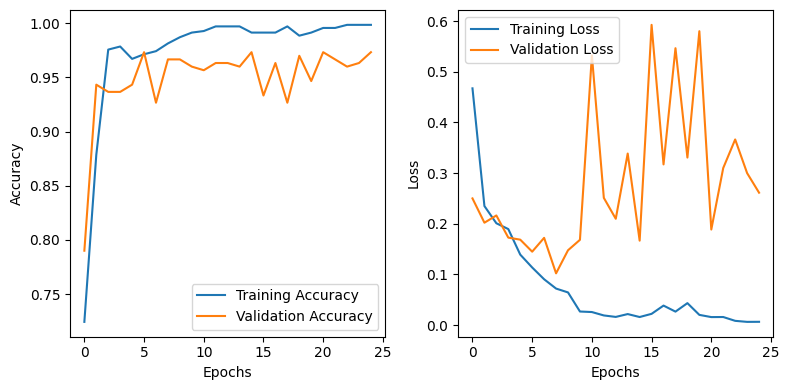

In [19]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

def visualize_hist(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    model = keras.models.load_model('model_pa2_cnn.keras')
    val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f'Validation accuracy: {val_accuracy}')
    visualize_hist(history)